In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dataset

In [2]:
df = pd.read_csv(
    'cansim-0800020-eng-6674700030567901031.csv',
    skiprows=6, skipfooter=9, engine='python')
df.head()

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083


### Adjust date

In [3]:
from pandas.tseries.offsets import MonthEnd

df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1)
df = df.set_index('Adjustments')

df.head()

,Unadjusted,Seasonally adjusted
Adjustments,,
1991-01-31,12588862,15026890
1991-02-28,12154321,15304585
1991-03-31,14337072,15413591
1991-04-30,15108570,15293409
1991-05-31,17225734,15676083


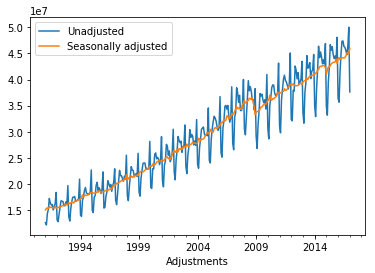

In [4]:
df.plot()

### Split train-testset

In [5]:
split_date = pd.Timestamp('01-01-2011')

train = df.loc[:split_date, ['Unadjusted']]
test = df.loc[split_date:, ['Unadjusted']]

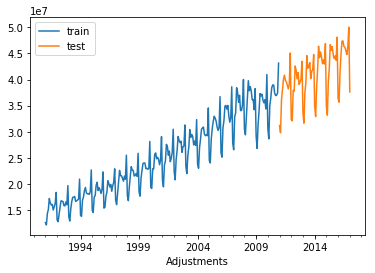

In [6]:
ax = train.plot();
test.plot(ax=ax)
plt.legend(['train', 'test']);

#### MinMax Scaling input

In [7]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

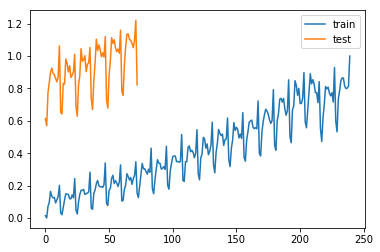

In [8]:
ax = pd.DataFrame(train_sc).plot();
pd.DataFrame(test_sc).plot(ax=ax)
plt.legend(['train', 'test']);

#### define train-testset 

In [9]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

# Models

## Fully connected

In [10]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

K.clear_session()

model = Sequential()

model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                24        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [11]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

In [12]:
model.fit(
    X_train, y_train,
    epochs=200,batch_size=2,
    verbose=1, callbacks=[early_stop])

Epoch 1/200
239/239 [==============================] - 1s 4ms/step - loss: 0.0945
Epoch 2/200
239/239 [==============================] - 0s 2ms/step - loss: 0.0371
Epoch 3/200
239/239 [==============================] - 0s 2ms/step - loss: 0.0242
Epoch 4/200
239/239 [==============================] - 0s 2ms/step - loss: 0.0218
Epoch 5/200
239/239 [==============================] - 1s 2ms/step - loss: 0.0202
Epoch 6/200
239/239 [==============================] - 0s 2ms/step - loss: 0.0187
Epoch 7/200
239/239 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 8/200
239/239 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 9/200
239/239 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 10/200
239/239 [==============================] - 1s 3ms/step - loss: 0.0136
Epoch 11/200
239/239 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 12/200
239/239 [==============================] - 1s 6ms/step - loss: 0.0120
Epoch 13/200


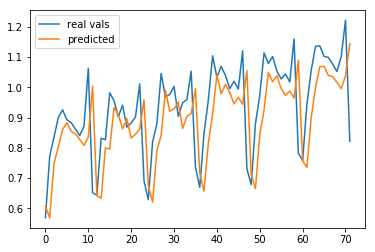

In [13]:
y_pred = model.predict(X_test)

plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['real vals', 'predicted']);

## LSTM

In [14]:
X_train.shape

(239, 1)

In [15]:
# Convert to tensor: (batch_size, timesteps, input_dim)
X_train_t = X_train[:, None]
X_test_t = X_test[:, None]

X_train_t.shape

(239, 1, 1)

In [16]:
from keras.models import Sequential
import keras.backend as K
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

K.clear_session()

model = Sequential()

model.add(LSTM(6, input_shape=(1, 1)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

In [18]:
model.fit(
    X_train_t, y_train,
    epochs=100, batch_size=1, verbose=1,
    callbacks=[early_stop])

Epoch 1/100
239/239 [==============================] - 3s 14ms/step - loss: 0.1460
Epoch 2/100
239/239 [==============================] - 2s 9ms/step - loss: 0.0453
Epoch 3/100
239/239 [==============================] - 2s 9ms/step - loss: 0.0359
Epoch 4/100
239/239 [==============================] - 2s 8ms/step - loss: 0.0290
Epoch 5/100
239/239 [==============================] - 2s 9ms/step - loss: 0.0232
Epoch 6/100
239/239 [==============================] - 3s 12ms/step - loss: 0.0185
Epoch 7/100
239/239 [==============================] - 2s 9ms/step - loss: 0.0150
Epoch 8/100
239/239 [==============================] - 2s 9ms/step - loss: 0.0125
Epoch 9/100
239/239 [==============================] - 2s 9ms/step - loss: 0.0112
Epoch 10/100
239/239 [==============================] - 2s 10ms/step - loss: 0.0107
Epoch 11/100
239/239 [==============================] - 2s 9ms/step - loss: 0.0104
Epoch 12/100
239/239 [==============================] - 3s 11ms/step - loss: 0.0104
Epoch 13/

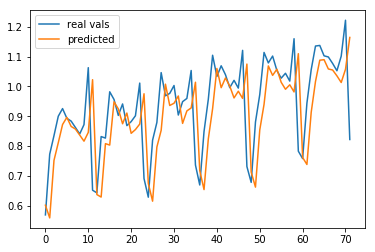

In [19]:
y_pred = model.predict(X_test_t)

plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['real vals', 'predicted']);